In [1]:
import pandas as pd
import pandas_profiling as pdp
import numpy as np
from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import lightgbm as lgb

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 150)

In [2]:
# データロード
train_2018_df = pd.read_csv('../data/input/train_2018.csv')
train_2017_df = pd.read_csv('../data/input/train_2017.csv')
train_2016_df = pd.read_csv('../data/input/train_2016.csv')
train_2018_df['year'] = 2018
train_2017_df['year'] = 2017
train_2016_df['year'] = 2016

test_df = pd.read_csv('../data/input/test.csv')
test_df['year'] = 2019

In [3]:
# 教師データとテストデータのunion
all_df = pd.concat([train_2016_df, train_2017_df, train_2018_df, test_df], axis = 0).reset_index(drop=True)

### 特徴量エンジニアリング

In [4]:
# データ概要
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1902 entries, 0 to 1901
Data columns (total 37 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   1902 non-null   int64  
 1   team                 1902 non-null   object 
 2   No                   1902 non-null   float64
 3   name                 1902 non-null   object 
 4   time_played          1414 non-null   float64
 5   position             1902 non-null   object 
 6   birthdate            1902 non-null   object 
 7   height               1902 non-null   float64
 8   weight               1902 non-null   float64
 9   salary               1902 non-null   object 
 10  nth_year             1902 non-null   float64
 11  is_youth             341 non-null    float64
 12  nationality          276 non-null    object 
 13  j1_total_num_played  1640 non-null   float64
 14  j1_total_scores      1554 non-null   float64
 15  j2_total_num_played  1134 non-null   f

In [5]:
# nationalityのNaN→Japan補完
all_df['nationality'] = all_df['nationality'].fillna('japan')

In [6]:
# team, name, position, nationalityのLabelEncoding
le = LabelEncoder()

for col in ['team', 'name', 'position', 'nationality']:
    le = le.fit(all_df[col])
    all_df[col] = le.transform(all_df[col])

In [7]:
# birthdateの年抽出
all_df['birthdate'] = pd.to_datetime(all_df['birthdate'])
all_df['birthdate_year'] = all_df['birthdate'].dt.year

In [8]:
# salaryのNaN→中央値補完
med_salary = all_df[all_df['salary'] != '-']['salary'].median()
all_df['salary'] = all_df['salary'].mask(all_df['salary'] == '-', med_salary)
all_df['salary'] = all_df['salary'].astype(float)

In [9]:
# team, name, position, nationalityのLabelEncoding
le = LabelEncoder()

for col in ['team', 'name', 'position', 'nationality']:
    le = le.fit(all_df[col])
    all_df[col] = le.transform(all_df[col])

In [11]:
# salaryのNaN→中央値補完
med_salary = all_df[all_df['salary'] != '-']['salary'].median()
all_df['salary'] = all_df['salary'].mask(all_df['salary'] == '-', med_salary)
all_df['salary'] = all_df['salary'].astype(float)

### 学習

In [12]:
# 教師, 検証データ
x_train_valid_df = all_df[all_df['year'] < 2019]
y_train_valid_df = x_train_valid_df['time_played']

# バリデーション
x_train, x_valid, y_train, y_valid = train_test_split(x_train_valid_df, y_train_valid_df, test_size=0.33, random_state=0)

# テストデータ
test = all_df[all_df['year'] == 2019]

In [13]:
# 入力する特徴量
features = [
    'team',
    'position',
    'height',
    'weight',
    'salary',
    'nth_year',
    'is_youth',
    'nationality',
    'birthdate_year',
    'year'
]

In [14]:
# カテゴリ変数
categorical_features = ['team', 'position', 'is_youth', 'nationality']

In [15]:
# lightgbmパラメータ
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse'
}

In [16]:
# lightGBM用のデータセットを作成
lgb_train = lgb.Dataset(x_train[features], y_train, categorical_feature = categorical_features)
lgb_eval = lgb.Dataset(x_valid[features], y_valid, categorical_feature = categorical_features)

# モデルの作成
evals_result = {}
model = lgb.train(params = lgb_params,
                  train_set = lgb_train,
                  valid_sets = [lgb_train, lgb_eval],
                  verbose_eval = 10,
                  num_boost_round = 1000,
                  early_stopping_rounds = 10
)

# モデルの精度
valid_pred = model.predict(x_valid[features])
model_score = np.sqrt(metrics.mean_squared_error(valid_pred, y_valid))
print(f'Our val rmse score is {model_score}.')

# テストデータの予測
y_pred = model.predict(test[features])
test['time_played'] = y_pred

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 786.263	valid_1's rmse: 905.149
[20]	training's rmse: 687.943	valid_1's rmse: 870.706
[30]	training's rmse: 619.356	valid_1's rmse: 857.983
[40]	training's rmse: 568.904	valid_1's rmse: 859.241
[50]	training's rmse: 523.944	valid_1's rmse: 855.388
Early stopping, best iteration is:
[47]	training's rmse: 536.23	valid_1's rmse: 853.522
Our val rmse score is 853.522094551548.


c:\users\mikan\python\venv\j-league_nishika\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
c:\users\mikan\python\venv\j-league_nishika\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


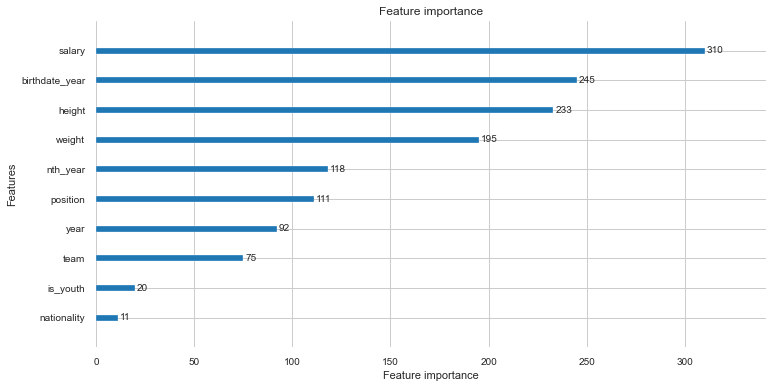

In [17]:
lgb.plot_importance(model, figsize=(12, 6))
plt.show()

### 出力

In [18]:
test[['id', 'time_played']].to_csv('../data/output/baseline.csv', index=False)